In [1]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/audible-dataset/audible_cleaned.csv
/kaggle/input/audible-dataset/audible_uncleaned.csv


# Imports

In [2]:
import regex as re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import plotly.graph_objects as go

import statsmodels.api as sm
from sklearn.feature_selection import mutual_info_regression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Preprocessing

In [3]:
df = pd.read_csv('/kaggle/input/audible-dataset/audible_uncleaned.csv')
df.head()

,name,author,narrator,time,releasedate,language,stars,price
0,Geronimo Stilton #11 & #12,Writtenby:GeronimoStilton,Narratedby:BillLobely,2 hrs and 20 mins,04-08-08,English,5 out of 5 stars34 ratings,468.00
1,The Burning Maze,Writtenby:RickRiordan,Narratedby:RobbieDaymond,13 hrs and 8 mins,01-05-18,English,4.5 out of 5 stars41 ratings,820.00
2,The Deep End,Writtenby:JeffKinney,Narratedby:DanRussell,2 hrs and 3 mins,06-11-20,English,4.5 out of 5 stars38 ratings,410.00
3,Daughter of the Deep,Writtenby:RickRiordan,Narratedby:SoneelaNankani,11 hrs and 16 mins,05-10-21,English,4.5 out of 5 stars12 ratings,615.00
4,"The Lightning Thief: Percy Jackson, Book 1",Writtenby:RickRiordan,Narratedby:JesseBernstein,10 hrs,13-01-10,English,4.5 out of 5 stars181 ratings,820.00


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87489 entries, 0 to 87488
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   name         87489 non-null  object
 1   author       87489 non-null  object
 2   narrator     87489 non-null  object
 3   time         87489 non-null  object
 4   releasedate  87489 non-null  object
 5   language     87489 non-null  object
 6   stars        87489 non-null  object
 7   price        87489 non-null  object
dtypes: object(8)
memory usage: 5.3+ MB


**How many unique values are in each col.**

In [5]:
for col in df.columns:
    print(f'{col}: {df[str(col)].nunique()}')

name: 82767
author: 48374
narrator: 29717
time: 2284
releasedate: 5058
language: 36
stars: 665
price: 1011


Remove 'Writtenby:' from the 'author' col.

In [6]:
df['author'].unique()

array(['Writtenby:GeronimoStilton', 'Writtenby:RickRiordan',
       'Writtenby:JeffKinney', ..., 'Writtenby:RogerW.Thompson',
       'Writtenby:ChrisStewart', "Writtenby:StephenO'Shea"], dtype=object)

In [7]:
def rem_writby(text):
    return ' '.join(re.sub( r"([A-Z])", r" \1", text[10:]).split())

In [8]:
author_list = list()
for i in df['author']:
    author_list.append(rem_writby(i))
author_list[0:10]

['Geronimo Stilton',
 'Rick Riordan',
 'Jeff Kinney',
 'Rick Riordan',
 'Rick Riordan',
 'Suzanne Collins',
 'Winter Morgan',
 'Rick Riordan',
 'Mary Pope Osborne',
 'Rick Riordan']

In [9]:
author_series = pd.Series(author_list)
# Replaces non 'Mon Year - Mon Year' Aired' values with NaN values
df = df.assign(authors = author_series)
df.head()

,name,author,narrator,time,releasedate,language,stars,price,authors
0,Geronimo Stilton #11 & #12,Writtenby:GeronimoStilton,Narratedby:BillLobely,2 hrs and 20 mins,04-08-08,English,5 out of 5 stars34 ratings,468.00,Geronimo Stilton
1,The Burning Maze,Writtenby:RickRiordan,Narratedby:RobbieDaymond,13 hrs and 8 mins,01-05-18,English,4.5 out of 5 stars41 ratings,820.00,Rick Riordan
2,The Deep End,Writtenby:JeffKinney,Narratedby:DanRussell,2 hrs and 3 mins,06-11-20,English,4.5 out of 5 stars38 ratings,410.00,Jeff Kinney
3,Daughter of the Deep,Writtenby:RickRiordan,Narratedby:SoneelaNankani,11 hrs and 16 mins,05-10-21,English,4.5 out of 5 stars12 ratings,615.00,Rick Riordan
4,"The Lightning Thief: Percy Jackson, Book 1",Writtenby:RickRiordan,Narratedby:JesseBernstein,10 hrs,13-01-10,English,4.5 out of 5 stars181 ratings,820.00,Rick Riordan


In [10]:
df = df.drop('author', axis = 1)

**Removing 'Narratedby:' from 'narrator' col.**

In [11]:
df['narrator'].unique()

array(['Narratedby:BillLobely', 'Narratedby:RobbieDaymond',
       'Narratedby:DanRussell', ..., 'Narratedby:JeanMarsh',
       'Narratedby:McAvoyLayne', 'Narratedby:ChrisStewart'], dtype=object)

In [12]:
def rem_natby(text):
    return ' '.join(re.sub( r"([A-Z])", r" \1", text[11:]).split())

In [13]:
nat_list = list()
for i in df['narrator']:
    nat_list.append(rem_natby(i))

In [14]:
nat_series = pd.Series(nat_list)
# Replaces non 'Mon Year - Mon Year' Aired' values with NaN values
df = df.assign(narrators = nat_series)
df.head()

,name,narrator,time,releasedate,language,stars,price,authors,narrators
0,Geronimo Stilton #11 & #12,Narratedby:BillLobely,2 hrs and 20 mins,04-08-08,English,5 out of 5 stars34 ratings,468.00,Geronimo Stilton,Bill Lobely
1,The Burning Maze,Narratedby:RobbieDaymond,13 hrs and 8 mins,01-05-18,English,4.5 out of 5 stars41 ratings,820.00,Rick Riordan,Robbie Daymond
2,The Deep End,Narratedby:DanRussell,2 hrs and 3 mins,06-11-20,English,4.5 out of 5 stars38 ratings,410.00,Jeff Kinney,Dan Russell
3,Daughter of the Deep,Narratedby:SoneelaNankani,11 hrs and 16 mins,05-10-21,English,4.5 out of 5 stars12 ratings,615.00,Rick Riordan,Soneela Nankani
4,"The Lightning Thief: Percy Jackson, Book 1",Narratedby:JesseBernstein,10 hrs,13-01-10,English,4.5 out of 5 stars181 ratings,820.00,Rick Riordan,Jesse Bernstein


**Changing 'Less than 1 minute' to half a minute**

In [15]:
df = df.replace(['Less than 1 minute'], '1')

In [16]:
df.loc[df['time'] == 'Less than 1 minute']

,name,narrator,time,releasedate,language,stars,price,authors,narrators


In [17]:
df = df.drop('narrator',axis = 1)

Change all values in the 'time' col. to be minutes

**Functions for altering 'time' col.**

In [18]:
def rm_mins(text):
    text.remove('mins')
    return text
    
def rm_min(text):
    text.remove('min')
    return text  

def sixty_hr(text):
    text[text.index('hr')] = '60'
    return text

def sixty_hrs(text):
    text[text.index('hrs')] = '60'
    return text

In [19]:
time_list = list()

for i in df['time']:
    i = i.split()
    # Removes 'mins' or 'min' from the text
    if 'mins' in i:
        i = rm_mins(i)
    elif 'min' in i:
        i = rm_min(i)
    # Transforms 'hr' or 'hrs' into int(60)
    if 'hr' in i:
        i = sixty_hr(i)
    elif 'hrs' in i:
        i = sixty_hrs(i)
        
    try:
        i.remove('and')
        time_list.append(i)
    except ValueError:
        time_list.append(i)

In [20]:
output = list()

for i in time_list:
    if '60' in i:
        output.append((int(i[i.index('60') - 1]) * int(60)) + int(i[-1]))
    else:
        output.append(int(i[0]))

In [21]:
# Assigns the values to a list and then to a series
time = pd.Series(output)
# Adds a ability 1 col.
df = df.assign(audible_length_m = time)
df.head()

,name,time,releasedate,language,stars,price,authors,narrators,audible_length_m
0,Geronimo Stilton #11 & #12,2 hrs and 20 mins,04-08-08,English,5 out of 5 stars34 ratings,468.00,Geronimo Stilton,Bill Lobely,140
1,The Burning Maze,13 hrs and 8 mins,01-05-18,English,4.5 out of 5 stars41 ratings,820.00,Rick Riordan,Robbie Daymond,788
2,The Deep End,2 hrs and 3 mins,06-11-20,English,4.5 out of 5 stars38 ratings,410.00,Jeff Kinney,Dan Russell,123
3,Daughter of the Deep,11 hrs and 16 mins,05-10-21,English,4.5 out of 5 stars12 ratings,615.00,Rick Riordan,Soneela Nankani,676
4,"The Lightning Thief: Percy Jackson, Book 1",10 hrs,13-01-10,English,4.5 out of 5 stars181 ratings,820.00,Rick Riordan,Jesse Bernstein,660


In [22]:
df = df.drop('time', axis = 1)

**Create a rating and number of raters col. **

In [23]:
df.head()

,name,releasedate,language,stars,price,authors,narrators,audible_length_m
0,Geronimo Stilton #11 & #12,04-08-08,English,5 out of 5 stars34 ratings,468.00,Geronimo Stilton,Bill Lobely,140
1,The Burning Maze,01-05-18,English,4.5 out of 5 stars41 ratings,820.00,Rick Riordan,Robbie Daymond,788
2,The Deep End,06-11-20,English,4.5 out of 5 stars38 ratings,410.00,Jeff Kinney,Dan Russell,123
3,Daughter of the Deep,05-10-21,English,4.5 out of 5 stars12 ratings,615.00,Rick Riordan,Soneela Nankani,676
4,"The Lightning Thief: Percy Jackson, Book 1",13-01-10,English,4.5 out of 5 stars181 ratings,820.00,Rick Riordan,Jesse Bernstein,660


In [24]:
def rm_num(text):
    return re.findall(r'\d+', text)

In [25]:
rating_list = list()
for i in df['stars']:
    rating_list.append(rm_num(i))
rating_list[0:10]

[['5', '5', '34'],
 ['4', '5', '5', '41'],
 ['4', '5', '5', '38'],
 ['4', '5', '5', '12'],
 ['4', '5', '5', '181'],
 ['5', '5', '72'],
 ['5', '5', '11'],
 ['5', '5', '50'],
 ['5', '5', '5'],
 ['5', '5', '58']]

In [26]:
rating = list()
raters = list()
for i in rating_list:
    if len(i) == 4:
        rating.append(float(f'{i[0]}.{i[1]}'))
        raters.append(int(i[3]))
    elif len(i) == 3:
        rating.append(float(i[0]))
        raters.append(int(i[2]))
    else:
        rating.append(0.0)
        raters.append(0)

**Creating a rating and number of raters col.**

Rating

In [27]:
# Assigns the values to a list and then to a series
rated_series = pd.Series(rating)
# Adds a ability 1 col.
df = df.assign(audible_rating = rated_series)
df.head()

,name,releasedate,language,stars,price,authors,narrators,audible_length_m,audible_rating
0,Geronimo Stilton #11 & #12,04-08-08,English,5 out of 5 stars34 ratings,468.00,Geronimo Stilton,Bill Lobely,140,5.0
1,The Burning Maze,01-05-18,English,4.5 out of 5 stars41 ratings,820.00,Rick Riordan,Robbie Daymond,788,4.5
2,The Deep End,06-11-20,English,4.5 out of 5 stars38 ratings,410.00,Jeff Kinney,Dan Russell,123,4.5
3,Daughter of the Deep,05-10-21,English,4.5 out of 5 stars12 ratings,615.00,Rick Riordan,Soneela Nankani,676,4.5
4,"The Lightning Thief: Percy Jackson, Book 1",13-01-10,English,4.5 out of 5 stars181 ratings,820.00,Rick Riordan,Jesse Bernstein,660,4.5


Raters

In [28]:
# Assigns the values to a list and then to a series
rater_series = pd.Series(raters)
# Adds a ability 1 col.
df = df.assign(rater_number = rater_series)
df.head()

,name,releasedate,language,stars,price,authors,narrators,audible_length_m,audible_rating,rater_number
0,Geronimo Stilton #11 & #12,04-08-08,English,5 out of 5 stars34 ratings,468.00,Geronimo Stilton,Bill Lobely,140,5.0,34
1,The Burning Maze,01-05-18,English,4.5 out of 5 stars41 ratings,820.00,Rick Riordan,Robbie Daymond,788,4.5,41
2,The Deep End,06-11-20,English,4.5 out of 5 stars38 ratings,410.00,Jeff Kinney,Dan Russell,123,4.5,38
3,Daughter of the Deep,05-10-21,English,4.5 out of 5 stars12 ratings,615.00,Rick Riordan,Soneela Nankani,676,4.5,12
4,"The Lightning Thief: Percy Jackson, Book 1",13-01-10,English,4.5 out of 5 stars181 ratings,820.00,Rick Riordan,Jesse Bernstein,660,4.5,181


In [29]:
df = df.drop('stars',axis = 1)

In [30]:
df.head()

,name,releasedate,language,price,authors,narrators,audible_length_m,audible_rating,rater_number
0,Geronimo Stilton #11 & #12,04-08-08,English,468.00,Geronimo Stilton,Bill Lobely,140,5.0,34
1,The Burning Maze,01-05-18,English,820.00,Rick Riordan,Robbie Daymond,788,4.5,41
2,The Deep End,06-11-20,English,410.00,Jeff Kinney,Dan Russell,123,4.5,38
3,Daughter of the Deep,05-10-21,English,615.00,Rick Riordan,Soneela Nankani,676,4.5,12
4,"The Lightning Thief: Percy Jackson, Book 1",13-01-10,English,820.00,Rick Riordan,Jesse Bernstein,660,4.5,181


**Rearange cols.**

In [31]:
df = df[['name', 'authors', 'narrators' ,'audible_length_m', 'releasedate', 'language',
        'price', 'audible_rating', 'rater_number']]
df.head()

,name,authors,narrators,audible_length_m,releasedate,language,price,audible_rating,rater_number
0,Geronimo Stilton #11 & #12,Geronimo Stilton,Bill Lobely,140,04-08-08,English,468.00,5.0,34
1,The Burning Maze,Rick Riordan,Robbie Daymond,788,01-05-18,English,820.00,4.5,41
2,The Deep End,Jeff Kinney,Dan Russell,123,06-11-20,English,410.00,4.5,38
3,Daughter of the Deep,Rick Riordan,Soneela Nankani,676,05-10-21,English,615.00,4.5,12
4,"The Lightning Thief: Percy Jackson, Book 1",Rick Riordan,Jesse Bernstein,660,13-01-10,English,820.00,4.5,181


In [32]:
df = df.convert_dtypes()

**Make a coded version of name, authors, narrators, language**

In [33]:
df['author_id'] = pd.factorize(df['authors'])[0] + 1
df['narrator_id'] = pd.factorize(df['narrators'])[0] + 1
df['name_id'] = pd.factorize(df['name'])[0] + 1
df['language_id'] = pd.factorize(df['language'])[0] + 1

In [34]:
df = df.convert_dtypes()

In [35]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87489 entries, 0 to 87488
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   name              87489 non-null  string 
 1   authors           87489 non-null  string 
 2   narrators         87489 non-null  string 
 3   audible_length_m  87489 non-null  Int64  
 4   releasedate       87489 non-null  string 
 5   language          87489 non-null  string 
 6   price             87489 non-null  string 
 7   audible_rating    87489 non-null  Float64
 8   rater_number      87489 non-null  Int64  
 9   author_id         87489 non-null  Int64  
 10  narrator_id       87489 non-null  Int64  
 11  name_id           87489 non-null  Int64  
 12  language_id       87489 non-null  Int64  
dtypes: Float64(1), Int64(6), string(6)
memory usage: 9.3 MB


**Turning 'price' into a float col.**

In [36]:
price_list = list()
for i in df['price']:
    if i == 'Free':
        price_list.append(0.0)
    else:
        i = i.replace(',', '')
        price_list.append(i)

In [37]:
# Assigns the values to a list and then to a series
price_series = pd.Series(price_list)
# Adds a ability 1 col.
df = df.assign(price_fixed = price_series)
df.head()

,name,authors,narrators,audible_length_m,releasedate,language,price,audible_rating,rater_number,author_id,narrator_id,name_id,language_id,price_fixed
0,Geronimo Stilton #11 & #12,Geronimo Stilton,Bill Lobely,140,04-08-08,English,468.00,5.0,34,1,1,1,1,468.00
1,The Burning Maze,Rick Riordan,Robbie Daymond,788,01-05-18,English,820.00,4.5,41,2,2,2,1,820.00
2,The Deep End,Jeff Kinney,Dan Russell,123,06-11-20,English,410.00,4.5,38,3,3,3,1,410.00
3,Daughter of the Deep,Rick Riordan,Soneela Nankani,676,05-10-21,English,615.00,4.5,12,2,4,4,1,615.00
4,"The Lightning Thief: Percy Jackson, Book 1",Rick Riordan,Jesse Bernstein,660,13-01-10,English,820.00,4.5,181,2,5,5,1,820.00


In [38]:
df['price_fixed'] = df['price_fixed'].astype(float)

In [39]:
df = df.drop('price', axis = 1)

**How many unique values in cols.**

In [40]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87489 entries, 0 to 87488
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   name              87489 non-null  string 
 1   authors           87489 non-null  string 
 2   narrators         87489 non-null  string 
 3   audible_length_m  87489 non-null  Int64  
 4   releasedate       87489 non-null  string 
 5   language          87489 non-null  string 
 6   audible_rating    87489 non-null  Float64
 7   rater_number      87489 non-null  Int64  
 8   author_id         87489 non-null  Int64  
 9   narrator_id       87489 non-null  Int64  
 10  name_id           87489 non-null  Int64  
 11  language_id       87489 non-null  Int64  
 12  price_fixed       87489 non-null  float64
dtypes: Float64(1), Int64(6), float64(1), string(5)
memory usage: 9.3 MB


**Create a month and year col. to see if month or year influence a movies popularity**

In [41]:
month_list = list()
year_list = list()

for i in df['releasedate']:
    month_list.append(i[3:5])
    year_list.append(i[6:])

In [42]:
# Assigns the values to a list and then to a series
month_series = pd.Series(month_list)
# Adds a ability 1 col.
df = df.assign(month = month_series)
df.head()

,name,authors,narrators,audible_length_m,releasedate,language,audible_rating,rater_number,author_id,narrator_id,name_id,language_id,price_fixed,month
0,Geronimo Stilton #11 & #12,Geronimo Stilton,Bill Lobely,140,04-08-08,English,5.0,34,1,1,1,1,468.0,08
1,The Burning Maze,Rick Riordan,Robbie Daymond,788,01-05-18,English,4.5,41,2,2,2,1,820.0,05
2,The Deep End,Jeff Kinney,Dan Russell,123,06-11-20,English,4.5,38,3,3,3,1,410.0,11
3,Daughter of the Deep,Rick Riordan,Soneela Nankani,676,05-10-21,English,4.5,12,2,4,4,1,615.0,10
4,"The Lightning Thief: Percy Jackson, Book 1",Rick Riordan,Jesse Bernstein,660,13-01-10,English,4.5,181,2,5,5,1,820.0,01


In [43]:
# Assigns the values to a list and then to a series
year_series = pd.Series(year_list)
# Adds a ability 1 col.
df = df.assign(year = year_series)
df.head()

,name,authors,narrators,audible_length_m,releasedate,language,audible_rating,rater_number,author_id,narrator_id,name_id,language_id,price_fixed,month,year
0,Geronimo Stilton #11 & #12,Geronimo Stilton,Bill Lobely,140,04-08-08,English,5.0,34,1,1,1,1,468.0,08,08
1,The Burning Maze,Rick Riordan,Robbie Daymond,788,01-05-18,English,4.5,41,2,2,2,1,820.0,05,18
2,The Deep End,Jeff Kinney,Dan Russell,123,06-11-20,English,4.5,38,3,3,3,1,410.0,11,20
3,Daughter of the Deep,Rick Riordan,Soneela Nankani,676,05-10-21,English,4.5,12,2,4,4,1,615.0,10,21
4,"The Lightning Thief: Percy Jackson, Book 1",Rick Riordan,Jesse Bernstein,660,13-01-10,English,4.5,181,2,5,5,1,820.0,01,10


**How many unique vals. per col.**

In [44]:
for col in df.columns:
    print(f'{col}: {df[str(col)].nunique()}')

name: 82767
authors: 48374
narrators: 29717
audible_length_m: 2280
releasedate: 5058
language: 36
audible_rating: 11
rater_number: 357
author_id: 48374
narrator_id: 29717
name_id: 82767
language_id: 36
price_fixed: 1011
month: 12
year: 28


In [45]:
df = df.convert_dtypes()

In [46]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87489 entries, 0 to 87488
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   name              87489 non-null  string 
 1   authors           87489 non-null  string 
 2   narrators         87489 non-null  string 
 3   audible_length_m  87489 non-null  Int64  
 4   releasedate       87489 non-null  string 
 5   language          87489 non-null  string 
 6   audible_rating    87489 non-null  Float64
 7   rater_number      87489 non-null  Int64  
 8   author_id         87489 non-null  Int64  
 9   narrator_id       87489 non-null  Int64  
 10  name_id           87489 non-null  Int64  
 11  language_id       87489 non-null  Int64  
 12  price_fixed       87489 non-null  Float64
 13  month             87489 non-null  string 
 14  year              87489 non-null  string 
dtypes: Float64(2), Int64(6), string(7)
memory usage: 10.7 MB


**Month and Year id col.**

In [47]:
df['month_id'] = pd.factorize(df['month'])[0] + 1
df['year_id'] = pd.factorize(df['year'])[0] + 1

In [48]:
df = df.convert_dtypes()

In [49]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87489 entries, 0 to 87488
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   name              87489 non-null  string 
 1   authors           87489 non-null  string 
 2   narrators         87489 non-null  string 
 3   audible_length_m  87489 non-null  Int64  
 4   releasedate       87489 non-null  string 
 5   language          87489 non-null  string 
 6   audible_rating    87489 non-null  Float64
 7   rater_number      87489 non-null  Int64  
 8   author_id         87489 non-null  Int64  
 9   narrator_id       87489 non-null  Int64  
 10  name_id           87489 non-null  Int64  
 11  language_id       87489 non-null  Int64  
 12  price_fixed       87489 non-null  Float64
 13  month             87489 non-null  string 
 14  year              87489 non-null  string 
 15  month_id          87489 non-null  Int64  
 16  year_id           87489 non-null  Int64 

# Feature Selection

In [50]:
quant_df = df[['name_id','author_id', 'narrator_id', 'audible_length_m',
               'language_id','price_fixed','month_id', 'year_id', 'audible_rating', 'rater_number']]

**Heatmap**

In [51]:
df_correlation = quant_df.corr()

# Heatmap 
fig = go.Figure(data=go.Heatmap(
    z=df_correlation.values,
    x=df_correlation.columns,
    y=df_correlation.columns,
    colorscale='RdBu',
    colorbar=dict(title='Correlation'),
))

# Heatmap layout
fig.update_layout(
    title='Audible Correlation Heatmap',
    xaxis=dict(title='Columns', tickangle=-45, automargin=True, tickfont=dict(size=10)),
    yaxis=dict(title='Columns', autorange='reversed', tickangle=0, automargin=True, tickfont=dict(size=10)),
    height=600,
)

fig.show()

**Mutual Information Score**

In [52]:
def calc_mi_score(X, y, df):
    mi_scores = mutual_info_regression(X, y, discrete_features=df)
    
    # Create an MI scores Series
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    
    # Sort the MI scores in descending order
    mi_scores = mi_scores.sort_values(ascending=False)
    
    return mi_scores

# Relevant features and labels
X = quant_df.select_dtypes(include=np.number).copy()
y = X.pop('audible_rating')

# Qualitative discrete features of the dataset (integer colls.)
discrete_feat = X.dtypes == float

mi_scores = calc_mi_score(X, y, discrete_feat)
mi_scores

rater_number        0.506796
name_id             0.173970
author_id           0.169312
narrator_id         0.131553
language_id         0.066356
price_fixed         0.062609
year_id             0.033356
audible_length_m    0.020773
month_id            0.000143
Name: MI Scores, dtype: float64

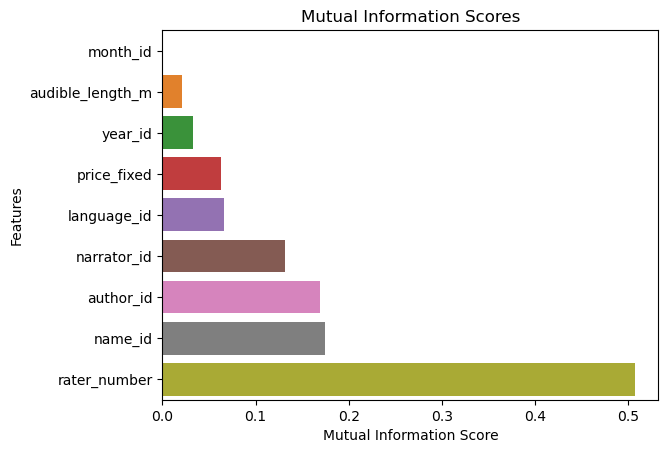

In [53]:
def plot_mi(scores):
    # Sort scores in ascending order
    scores = scores.sort_values(ascending=True)
    
    # Extract scores and feature names
    width = scores
    ticks = scores.index
    
    # Bar chart
    sns.barplot(x=width, y=ticks, orient='h')
    
    plt.title("Mutual Information Scores")
    plt.ylabel("Features")
    plt.xlabel("Mutual Information Score")
    
    plt.show()
plot_mi(mi_scores)

**Determine feature importance through Random Forest models**

In [54]:
X_df = df[['audible_length_m','rater_number','author_id',   
            'narrator_id','name_id','language_id','price_fixed','month_id','year_id']]

normalized_X = (X_df-X_df.mean())/X_df.std()

Text(0.5, 1.0, 'Audible Feature Importance')

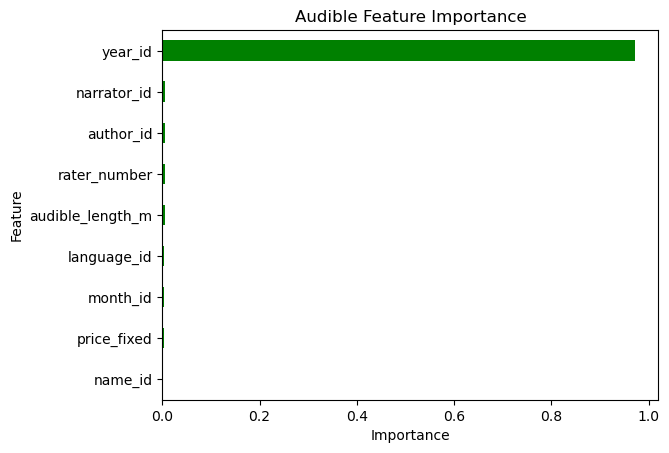

In [55]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 0)
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

global_importances = pd.Series(rf.feature_importances_, index=normalized_X.columns)
global_importances.sort_values(ascending=True, inplace=True)
global_importances.plot.barh(color='green')
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Audible Feature Importance")